In [51]:
import torch
import numpy as np

import sys
sys.path.append("Deep-Compression-PyTorch/")

lenet = torch.load("Deep-Compression-PyTorch/saves/initial_lenet_model.ptmodel")
lenet_compressed = torch.load("Deep-Compression-PyTorch/saves/model_lenet_after_retraining.ptmodel")

lenet

LeNet(
  (fc1): MaskedLinear(in_features=784, out_features=300, bias=False)
  (fc2): MaskedLinear(in_features=300, out_features=100, bias=False)
  (fc3): MaskedLinear(in_features=100, out_features=10, bias=False)
)

In [52]:
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        if 'mask' in name:
            continue
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')

print_nonzeros(lenet_compressed)

fc1.weight           | nonzeros =   11652 /  235200 (  4.95%) | total_pruned =  223548 | shape = (300, 784)
fc2.weight           | nonzeros =    2108 /   30000 (  7.03%) | total_pruned =   27892 | shape = (100, 300)
fc3.weight           | nonzeros =      51 /    1000 (  5.10%) | total_pruned =     949 | shape = (10, 100)
alive: 13811, pruned : 252389, total: 266200, Compression rate :      19.27x  ( 94.81% pruned)


In [53]:
fc1 = lenet.fc1.weight[:].detach().cpu().numpy()
fc2 = lenet.fc2.weight[:].detach().cpu().numpy()
fc3 = lenet.fc3.weight[:].detach().cpu().numpy()

fc1_compress = lenet_compressed.fc1.weight[:].detach().cpu().numpy()
fc2_compress = lenet_compressed.fc2.weight[:].detach().cpu().numpy()
fc3_compress = lenet_compressed.fc3.weight[:].detach().cpu().numpy()

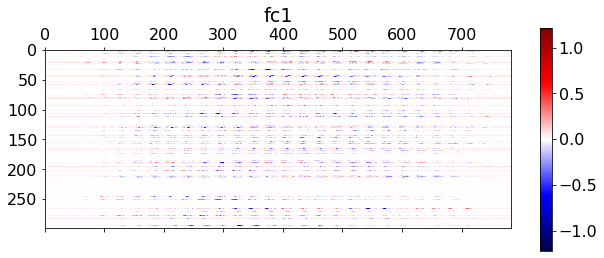

100%|██████████| 300/300 [00:00<00:00, 588.57it/s]


There are totally 0 zero elements in this matrix, percentage is 0.0


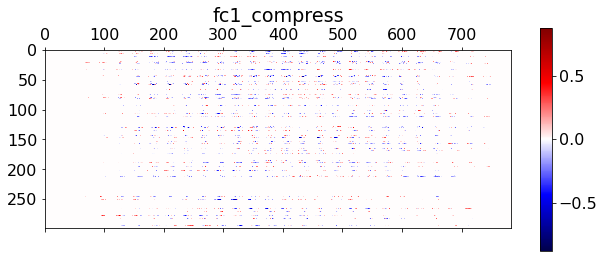

100%|██████████| 300/300 [00:00<00:00, 584.27it/s]


There are totally 223548 zero elements in this matrix, percentage is 0.9504591836734694


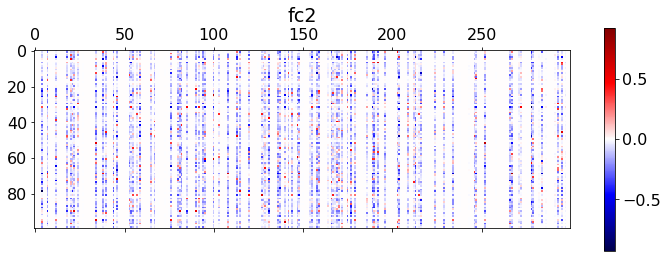

100%|██████████| 100/100 [00:00<00:00, 1544.73it/s]


There are totally 0 zero elements in this matrix, percentage is 0.0


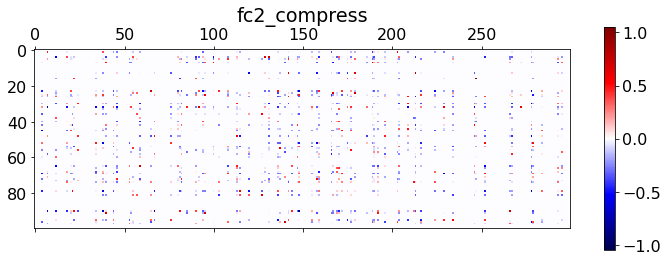

100%|██████████| 100/100 [00:00<00:00, 1520.94it/s]

There are totally 27892 zero elements in this matrix, percentage is 0.9297333333333333


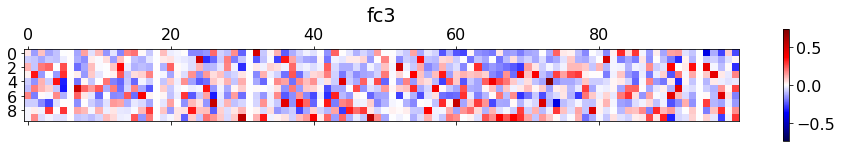

100%|██████████| 10/10 [00:00<00:00, 4469.63it/s]


There are totally 0 zero elements in this matrix, percentage is 0.0


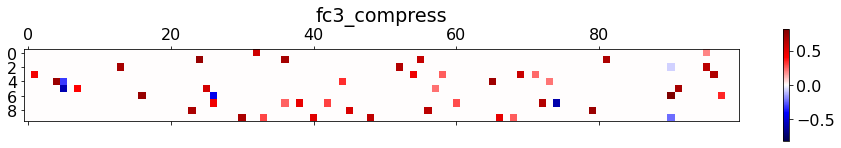

100%|██████████| 10/10 [00:00<00:00, 4487.33it/s]

There are totally 949 zero elements in this matrix, percentage is 0.949


In [54]:
from analyze_model import *
## directly plot the matrix as a 2D figure
import matplotlib.pyplot as plt



Plot2DMatrix(fc1, matrix_name="fc1", color_map="seismic")
Plot2DMatrix(fc1_compress, matrix_name="fc1_compress", color_map="seismic")

Plot2DMatrix(fc2, matrix_name="fc2", color_map="seismic")
Plot2DMatrix(fc2_compress, matrix_name="fc2_compress", color_map="seismic")

Plot2DMatrix(fc3, matrix_name="fc3", color_map="seismic")
Plot2DMatrix(fc3_compress, matrix_name="fc3_compress", color_map="seismic")

Process the matrix into abstracted vector-vectpro product task sizes, masking layer matrix details.

100%|██████████| 10/10 [00:00<00:00, 4574.44it/s]


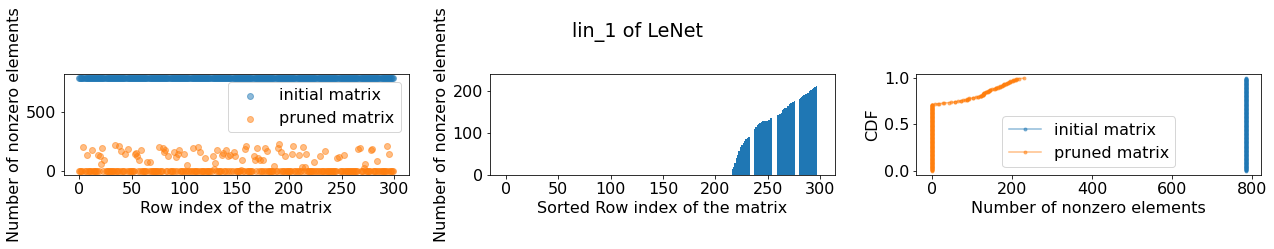

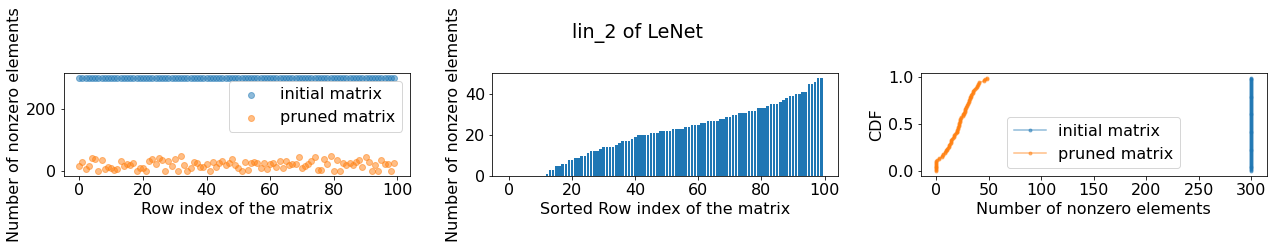

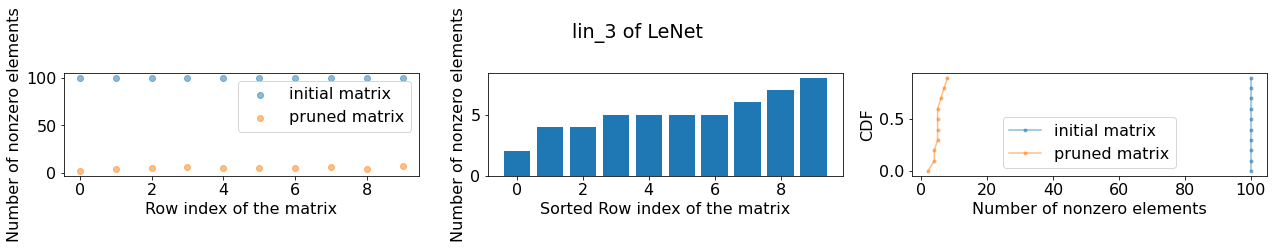

In [55]:
fc1_row_nonzero_set, fc1_pruned_row_nonzero_set = PlotVectorSizes(fc1, fc1_compress, "lin_1 of LeNet", plot_two_matrces=True)
fc2_row_nonzero_set, fc2_pruned_row_nonzero_set = PlotVectorSizes(fc2, fc2_compress, "lin_2 of LeNet", plot_two_matrces=True)
fc3_row_nonzero_set, fc3_pruned_row_nonzero_set = PlotVectorSizes(fc3, fc3_compress, "lin_3 of LeNet", plot_two_matrces=True)

In [56]:
from torchvision import datasets, transforms
import torch.nn.functional as F

def test(model, datasets, use_cuda):
    # Select Device
    use_cuda = use_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else 'cpu')
    if use_cuda:
        print("Using CUDA!")
        torch.cuda.manual_seed(42)
    else:
        print('Not using CUDA!!!')
        
    test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/home/zhizhenz/lightning-master/simulation/models/Deep-Compression-PyTorch/data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=50, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return accuracy

pre_accuracy = test(lenet, datasets, use_cuda=True)
print("Initial LeNet model accuracy on MNIST is {}".format(pre_accuracy))

post_accuracy = test(lenet_compressed, datasets, use_cuda=True)
print("Pruned LeNet model accuracy on MNIST is {}".format(post_accuracy))

Using CUDA!
Test set: Average loss: 0.2449, Accuracy: 9359/10000 (93.59%)
Initial LeNet model accuracy on MNIST is 93.59
Using CUDA!
Test set: Average loss: 0.1295, Accuracy: 9621/10000 (96.21%)
Pruned LeNet model accuracy on MNIST is 96.21


In [57]:
import pickle

pickle.dump(fc1, open("../../data/saved_models/lenet/fc_1.p", "wb"))
pickle.dump(fc1_compress, open("../../data/saved_models/lenet/compressed_fc_1.p", "wb"))
pickle.dump(fc2, open("../../data/saved_models/lenet/fc_2.p", "wb"))
pickle.dump(fc2_compress, open("../../data/saved_models/lenet/compressed_fc_2.p", "wb"))
pickle.dump(fc3, open("../../data/saved_models/lenet/fc_3.p", "wb"))
pickle.dump(fc3_compress, open("../../data/saved_models/lenet/compressed_fc_3.p", "wb"))

pickle.dump(fc1_row_nonzero_set, open("../../data/saved_models_shape/lenet/fc_1_tetris_shape.p", "wb"))
pickle.dump(fc2_row_nonzero_set, open("../../data/saved_models_shape/lenet/fc_2_tetris_shape.p", "wb"))
pickle.dump(fc3_row_nonzero_set, open("../../data/saved_models_shape/lenet/fc_3_tetris_shape.p", "wb"))
pickle.dump(fc1_pruned_row_nonzero_set, open("../../data/saved_models_shape/lenet/compressed_fc_1_tetris_shape.p", "wb"))
pickle.dump(fc2_pruned_row_nonzero_set, open("../../data/saved_models_shape/lenet/compressed_fc_2_tetris_shape.p", "wb"))
pickle.dump(fc3_pruned_row_nonzero_set, open("../../data/saved_models_shape/lenet/compressed_fc_3_tetris_shape.p", "wb"))

print("model saved in pickle files")

model saved in pickle files


Finally, with all the details of the LeNet model figured out, let us try to run the LeNet model purely using linear algebra and nonlinear functions, without PyTorch. This will be an emulation of running computation on photonic computing.

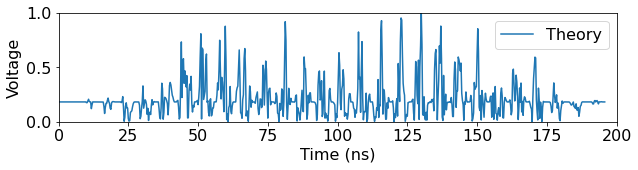

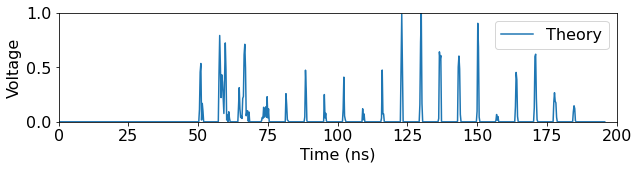

Actual picture for inference:


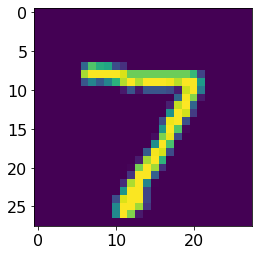

Result is 7 (tensor([-2811.4523, -2255.5353, -1990.6804, -2013.1127, -1837.8128, -2733.1378,
        -3173.4506,     0.0000, -2694.2364, -1433.9784], dtype=torch.float64))


/tmp/ipykernel_631755/3633480922.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  result = Log_Softmax(torch.tensor(output_2))


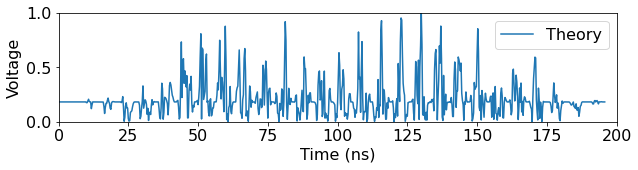

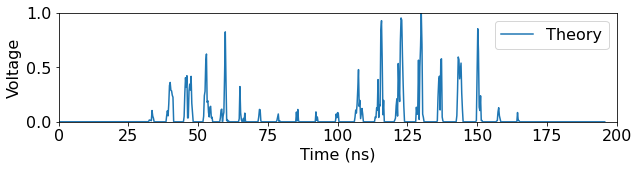

Actual picture for inference:


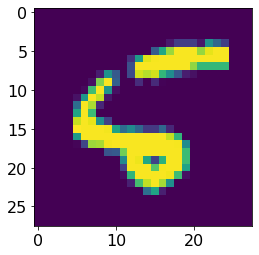

Result is 6 (tensor([ -951.7536, -1244.1600,  -792.4171, -1111.5660, -1010.3694,  -439.4716,
            0.0000, -1407.3887,  -562.5150, -1287.1365], dtype=torch.float64))


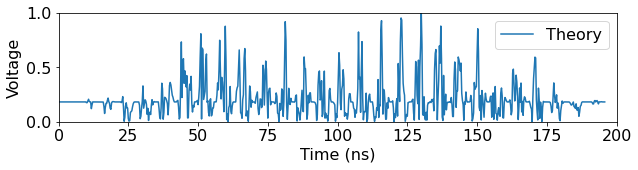

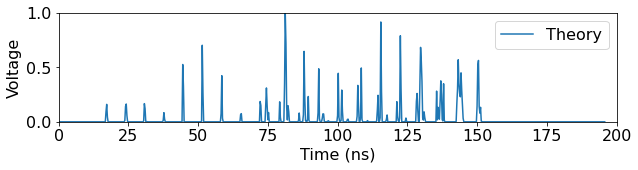

Actual picture for inference:


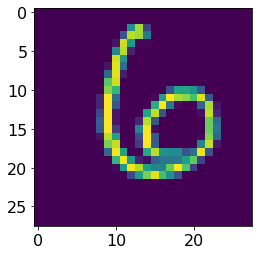

Result is 6 (tensor([-391.1390, -778.3786, -309.6023, -824.5199, -620.8475, -688.4996,
           0.0000, -883.7275, -448.5695, -879.7042], dtype=torch.float64))


In [69]:
import torch
from torchvision import datasets, transforms

def ReLU(input):
    output = np.zeros(input.shape) 
    for i in range(len(input)):
        if input[i] > 0:
            output[i] = input[i]
        else:
            output[i] = 0

    return output

# Run inference using purely matrix multiplication and nonlinear, this is purely computation without framework (tensorflow, pytorch, etc) support
def EmulatePhotonicInference(image):
    input = image.reshape(image.shape[0]*image.shape[1])
    input_0 = np.array(input)

    # first layer
    output_0 = np.matmul(fc1, input_0)
    input_1 = ReLU(output_0)
    
    plt.figure(figsize=(10,2))
    plt.plot([x/4 for x in range(784)], [abs(x/max(abs(fc1[0].reshape(784)))) for x in fc1[0].reshape(784)], label="Theory")
    plt.legend(loc="upper right", fontsize=16)
    plt.xlabel("Time (ns)", fontsize=16)
    plt.ylabel("Voltage", fontsize=16)
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    plt.show()
    
    plt.figure(figsize=(10,2))
    mul = [abs(fc1[0][x] * input_0[x]) for x in range(784)]
    plt.plot([x/4 for x in range(784)], [abs(x/max(mul)) for x in mul], label="Theory")
    plt.legend(loc="upper right", fontsize=16)
    plt.xlabel("Time (ns)", fontsize=16)
    plt.ylabel("Voltage", fontsize=16)
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    plt.show()


    # second layer
    output_1 = np.matmul(fc2, input_1)
    input_2 = ReLU(output_1)

    # third layer
    output_2 = np.matmul(fc3, input_2)
    Log_Softmax = torch.nn.LogSoftmax()

    print("Actual picture for inference:")
    plt.figure()
    plt.imshow(image)
    plt.show()
    
    result = Log_Softmax(torch.tensor(output_2))

    return result


## getting the MNIST dataset
mnistdata = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=50, shuffle=False)

## haha! let us run some inference, using photonics! 
image_0 = mnistdata.dataset.data[0,:,:]
result_0 = EmulatePhotonicInference(image_0)
print("Result is {} ({})".format(np.argmax(result_0), result_0))

image_8 = mnistdata.dataset.data[8,:,:]
result_8 = EmulatePhotonicInference(image_8)
print("Result is {} ({})".format(np.argmax(result_8), result_8))

image_100 = mnistdata.dataset.data[100,:,:]
result_100 = EmulatePhotonicInference(image_100)
print("Result is {} ({})".format(np.argmax(result_100), result_100))

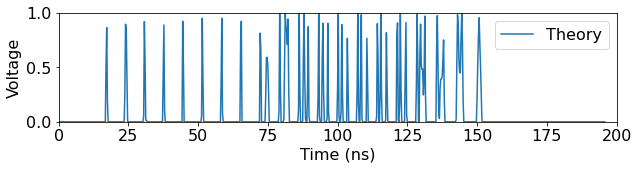

In [70]:
image_100.reshape(784)

plt.figure(figsize=(10,2))
plt.plot([x/4 for x in range(784)], [x/max(image_100.reshape(784)) for x in image_100.reshape(784)], label="Theory")
plt.legend(loc="upper right", fontsize=16)
plt.xlabel("Time (ns)", fontsize=16)
plt.ylabel("Voltage", fontsize=16)
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.show()